### Visualizing Behavior

In this script, a class, 'behaVid', has been created. Each instance of this class will be associated with a single animal. The behaVid class includes methods to parse data, compute values such as the neuron's instantaneous firing rate and generate/save a series of .png images that can be compiled into a continuous animation using an external program (i.e. ImageJ). At this time, the script is being tested on animal # 24116.

J. Carpenter 2020

In [1]:
# import libraries
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import scipy.ndimage
from scipy import stats
%matplotlib inline

In [2]:
# load dataset (for animal 24116)
fileLoc = "D:\\Data\\Dataset\\24116.mat"
matfile = sio.loadmat(fileLoc) # load .mat file

# parse relevant variables
SpikeTrain = matfile["SpikeTrain"][0] 
SpikeTimes = matfile["SpikeTimes"][0]
pos = matfile["pos"][0]
UniqueID = matfile["UniqueID"][0]
trialType = matfile["trialType"][0]
hd = matfile["hd"][0]

C:\Users\17145\Anaconda3\lib\site-packages\scipy\io\matlab\mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [3]:
# for now I just manually copied the HW locations (read in the labnotes later)
hwLoc = np.array([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 36, 37, 36, 36, 36, 36, 37, 37, 37, 36, 36, 37, 37, 37, 37, 37, 37, 37, 37])

In [202]:
# create class
class behaVid:
    
    def __init__(self, animalID, pos, SpikeTrain, SpikeTimes, UniqueID, trialType, hd, hwLoc):
        self.animalID = animalID
        self.pos = pos
        self.SpikeTrain = SpikeTrain
        self.SpikeTimes = SpikeTimes
        self.UniqueID = UniqueID
        self.trialType = trialType
        self.hd = hd
        self.hwLoc = hwLoc
        
    # methods
    
    def instFR(self, sigma=2, sessNum=0, unitNum=0):
        """
        Description: Returns a smoothed, instantaneous firing rate vector for a single unit.

        Inputs:
        'matfile'        matfile from dataset folder that includes information
                         for a single animal.
        'sigma'          number of standard deviations used to create the 1d Gaussian kernel
        'sessNum'        session/trial number of interest
        'unitNum'        unit/cell number of interest

        Outputs:
        'fr'             smoothed firing rate of the unit
        """
        # import libraries
        import scipy.ndimage
        from scipy import stats

        # parse spike data
        spikesNow = self.SpikeTrain[sessNum][0][unitNum][0] # grab spikes for session 

        # get sampling frequency
        Fs = self.sampleFreq(sessNum)

        # compute instantaneous FR
        firingRate = spikesNow/Fs # in Hz (spikes/second)

        # smooth rate with a Gaussian kernel (100 or 200 ms)
        fr = scipy.ndimage.gaussian_filter1d(firingRate, sigma)

        return fr
    
    
    def sampleFreq(self, sessNum=0):
        # get sampling frequency
        t = self.pos[sessNum][:,0] # grab time vector
        Fs, cnt = stats.mode(np.diff(t)) # calc mode of sampling frequencies
        Fs = np.around(np.amax(Fs[0]), decimals=2)
        
        return Fs
    
    
    
    def activityHist(self, sigma=2, numBins=15, sessNum=0, unitNum=0, doPlot=False):
        # make instantaneous fr histogram
        fr = self.instFR(sigma, sessNum, unitNum)
        peakRate = np.around(np.amax(fr), decimals=2)
        meanRate = np.around(np.mean(fr), decimals=2)
        binVector = np.linspace(0, peakRate, num = numBins)
        hist,bin_edges = np.histogram(fr, bins=binVector)

        # compute proportion of cells in each bin
        totalCnt = len(fr)
        propCells = hist/totalCnt

        # return bin indices to which each value belongs
        binInd = np.digitize(fr, binVector)
        
        if doPlot == True:
            # plot histogram
            plt.figure(figsize=[10,8])
            plt.bar(bin_edges[:-1], hist/totalCnt, width = 0.5, color='silver',alpha=0.7);
            plt.xlim(min(bin_edges), max(bin_edges))
            plt.ylim([0, .005])
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel('Value',fontsize=15)
            plt.ylabel('Frequency',fontsize=15)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.ylabel('Frequency',fontsize=15)
            plt.title('Activity Histogram',fontsize=15)
            plt.show()
        
        return binInd
        
    def numSpikes(self):
        
        totalSpikes = np.array([]) # initiate array
        
        for sessNum in range(39):
            ST_now = self.SpikeTimes[sessNum][0]
            numCells = len(ST_now)
            for i in ST_now:
                totalSpikes = np.append(totalSpikes, len(i))
                
        return totalSpikes
    
    def activityNow(self, sessNum=0, unitNum=0, timePoint=0, sigma=2):
        
        # parse data
        fr = self.instFR(sigma, sessNum, unitNum) # compute firing rate
        t = self.pos[sessNum][:,0] # time
        Fs, cnt = stats.mode(np.diff(t)) # sampling frequency

        # define range of points to pull from L/R sides of timePoint
        plusMinus = int(1/Fs)
        
        # index vectors, where len(frNow) = (plusMinus*2)+1
        # go back and pad beginning & end
        if timePoint < 50:
            frNow = fr[0:timePoint+plusMinus+1]
            timeNow = t[0:timePoint+plusMinus+1]
        elif timePoint > len(t)-50:
            frNow = fr[timePoint-plusMinus:end]
            timeNow = t[timePoint-plusMinus:end]
        else:
            frNow = fr[timePoint-plusMinus:timePoint+plusMinus+1] 
            timeNow = t[timePoint-plusMinus:timePoint+plusMinus+1]
        
        return frNow, timeNow
    
    
    
    def getUnitData(self, sessNum=0, unitNum=0):
    
        # trial type, spike train, unique ID #
        spikesNow = self.SpikeTrain[sessNum][0][unitNum][0]
        trialNow = str(self.trialType[sessNum][0])
        idNow = str(self.UniqueID[sessNum][0][unitNum][0][0])
        info = [idNow, sessNum, trialNow]
        
        # FIX THIS!!!!!!!!!!!!!****
        # get window maximums and minumums
        minX = float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0])
        maxX = float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0])
        minY = float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0])
        maxY = float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0])
        window = np.array([minX, maxX, minY, maxY])

        return window, spikesNow, info
    
    
    
    def getWindow(self, sessNum=0):
        
        # get window maximums and minumums
        minX = float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0])
        maxX = float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0])
        minY = float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0])
        maxY = float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0])
        window = np.array([minX, maxX, minY, maxY])
        
        return window

    
    
    def getMaxMin(self, matfile, sessNum=0, unitNum=0):
        # find max/min x/y coordinates (not window values)
        minX = float(matfile["sessInfo"][0][sessNum][0]["min_x"][0][0][0][0])
        maxX = float(matfile["sessInfo"][0][sessNum][0]["max_x"][0][0][0][0])
        minY = float(matfile["sessInfo"][0][sessNum][0]["min_y"][0][0][0][0])
        maxY = float(matfile["sessInfo"][0][sessNum][0]["max_y"][0][0][0][0])
        
        return minX, maxX, minY, maxY
        


    
    def getTimePt(self, sessNum=0, timePoint=0):

        # parse position vector 
        pos = matfile["pos"][0]
        time = self.pos[sessNum][:,0][timePoint];
        led1A = self.pos[sessNum][:,1][timePoint]; led1B = self.pos[sessNum][:,2][timePoint];
        led2A = self.pos[sessNum][:,3][timePoint]; led2B = self.pos[sessNum][:,4][timePoint];
        led = np.array([time, led1A, led1B, led2A, led2B])

        return time, led


    
    def plotBehavior(self, sessNum=0, unitNum=0, timePoint=0):
        """
        Description: plots behavior for a single timepoint.
        
        Inputs:
        'led'            output from 'getTimePt' method
        'window'         output from 'getUnitData' method
        'info'           output from 'getUnitData' method
        
        Outputs:
        Generates a single .png file that is saved in specified file location (hard-coded for now). 
        This .png file can be compiled in external software (i.e. imageJ) with other .png files from 
        the session to create an animation of the tracking/spiking activity.
        
        * To-do: Decide optimal way to organize this method & 'getTimePt'/'getUnitData' methods.
        """
        
        # call 'getTimePt', 'getUnitData' and 'instFR' methods 
        time, led = self.getTimePt(sessNum, timePoint)
        window, spikesNow, info = self.getUnitData(sessNum, unitNum)
        fr = self.instFR(sigma=2, sessNum=0, unitNum=0)
        
        # home well for current session?
        hwNow = hwLoc[sessNum]
        
        # calculate peak firing rate
        peakRate = np.around(np.amax(fr), decimals=2)
        
        # parse window vector
        scalingFactor = 1.10 # scale up min/max by some percentage
        minX = window[0]*scalingFactor; maxX = window[1]*scalingFactor; minY = window[2]*scalingFactor; maxY = window[3]*scalingFactor
        
        # compute space (x and y)-- this is to plot the grid
        xSpace = maxX-minX
        ySpace = maxY-minY
        
        
        # if size of the arena is not square, force aspect ratio
        # the idea here is that by shifting the arena to the right, we kind of force outliers out
        if xSpace > ySpace:
            diffSpace = xSpace-ySpace
            minX = minX + diffSpace # reshape the arena (make it square)
            numWells = 6 # in a single dimension
            Space = (maxY-minY)/(numWells+1) # space between points

        # parse led vector
        offset = 10 # how much to offset LEDs by
        time = led[0]
        L1A = led[1]; L1B = led[2]; L2A = led[3]+offset; L2B = led[4]+offset
        
        # call 'activityNow' method to get smoothed FR and time vector around the
        # timePoint of interest (+/- 1 second)
        fr_2, t = self.activityNow(sessNum, unitNum, timePoint, sigma=2)
        fr_3, _ = self.activityNow(sessNum, unitNum, timePoint, sigma=3)

        #####
        
        # (move this to preamble)- once fn is complete
        from matplotlib.gridspec import GridSpec
        
        # initialize figure
        w,h = plt.rcParams["figure.figsize"]
        # Define dimensions in inches (could also just put numbers here)
        left = plt.rcParams["figure.subplot.left"] * w
        right = (1 - plt.rcParams["figure.subplot.right"]) * w
        wspace = plt.rcParams["figure.subplot.wspace"] * w

        figw1, figh1 = (7,5)
        ax1width = figw1 - left - right
        ax2width = 3.5

        # calculate remaining free parameter, the figure width of the enlarged figure
        figh2 = figh1
        figw2 = left + ax1width + wspace + ax2width + right

        # calculate subplot parameters for both cases
        subplotpars1 = dict(left = left/figw1, right=(left + ax1width + wspace + ax2width)/figw1,
                            wspace=wspace/(ax1width+ax2width), )
        subplotpars2 = dict(left = left/figw2, right=(left + ax1width + wspace + ax2width)/figw2,
                            wspace=wspace/(ax1width+ax2width), )

        # create GridSpec
        gs = GridSpec(2,2, width_ratios=(ax1width, ax2width), **subplotpars1)
        
        # Create figure with 3 axes
        fig = plt.figure(23, figsize=(figw1, figh1))
        plt.clf()
        ax1 = fig.add_subplot(gs[0,0]) #, frameon=False)        
        ax2 = fig.add_subplot(gs[1,0]) #, frameon=False)
        ax3 = fig.add_subplot(gs[:,1]) #, frameon=False)
        
        # generate plot title
        AID = self.animalID
        UID = self.getUID(sessNum=sessNum, unitNum=unitNum) # get unique cell identifier
        TT = str(info[2]) # trial type
        plot_title = 'ANIMAL:' + AID + '   UID:' + str(UID) + '   SESS:' + str(info[1]) + '   TYPE:' + str(info[2])
        fig.suptitle(plot_title, fontsize=13)
        
        # define font sizes for plot
        axLabelSz = 12
        
        ax1.plot(t, fr_2, color='k')
        ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove x-ticks
        ax1.set_ylabel("fr (Hz)", fontsize=axLabelSz)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.set_ylim([0, peakRate])
        
        ax2.plot(t, fr_3, color='k') # smoothed 3 SDs
        ax2.set_xlabel("time (s)", fontsize=axLabelSz)
        ax2.set_ylabel("fr (Hz)",fontsize=axLabelSz)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.vlines(x = time, ymin = 0, ymax = 10, color='r', lw = 1.5) # current time
        ax2.set_ylim([0, peakRate])
        
        ax3.hlines(y = minY, xmin = minX, xmax = maxX, linestyles=':', lw = 1) #minY
        ax3.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles=':', lw = 1) # maxY
        ax3.vlines(x = minX, ymin = minY, ymax = maxY, linestyles=':', lw = 1) # minX
        ax3.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles=':', lw = 1) # maxX
        ax3.scatter(L1A, L1B, s=25, color='red') # plot data
        ax3.scatter(L2A, L2B, s=25, color='blue') # plot data
        ax3.axis('off')
        ax3.set_yticks([100, 200, 300, 400, 500]) 
        ax3.set_xticks([200, 300, 400, 500, 600]) 
        
        # if the trial is a 'FM', overlay grid
        if TT == 'FM':
            # plot grid
            testX = np.array([minX+Space, minX+Space*2, minX+Space*3, minX+Space*4, minX+Space*5, minX+Space*6])
            testY = np.array([minY+Space, minY+Space*2, minY+Space*3, minY+Space*4, minY+Space*5, minY+Space*6])
            
            if hwNow == 36:
                Kount = 1
                for xx in testX:
                    for yy in testY:
                        if Kount == 36:
                            ax3.scatter(xx,yy, s=60, color = "gold",  marker="*", edgecolors= "darkgoldenrod")
                            Kount = Kount + 1
                        else:
                            ax3.scatter(xx,yy, color = "silver")
                            Kount = Kount + 1
                            
                midX = minX+((maxX-minX)/2)
                midY = minY+((maxY-minY)/2)
                ax3.scatter(midX,midY, color = "silver")
                
            elif hwNow == 37:
                Kount = 1
                for xx in testX:
                    for yy in testY:
                        ax3.scatter(xx,yy, color = "silver")
                        Kount = Kount + 1
                        
                midX = minX+((maxX-minX)/2)
                midY = minY+((maxY-minY)/2)
                ax3.scatter(midX,midY, s= 60, color = "gold", marker="*", edgecolors= "darkgoldenrod")

        return fig
    
    
    def plotAllUnits(self, sessNum=0, timePoint=0):

        # find number of cells in the session
        numCells = len(self.SpikeTimes[sessNum][0])

        fig = plt.figure(figsize=(11,5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        # try to find y-lim of FR plot
        allPeaks = np.array([]);
        for unitNum in range(numCells):
            fr = self.instFR(sigma=2, sessNum=sessNum, unitNum=unitNum)
            maxVal = np.around(np.amax(fr), decimals=2);
            allPeaks = np.append(allPeaks, maxVal)
            
        overallPeak = np.max(allPeaks)
        y_offset = 0

        for unitNum in range(numCells):

            # call 'getTimePt', 'getUnitData' and 'instFR' methods 
            time, led = self.getTimePt(sessNum, timePoint)
            window, spikesNow, info = self.getUnitData(sessNum, unitNum)
            fr = self.instFR(sigma=2, sessNum=sessNum, unitNum=unitNum)
            UID = self.getUID(sessNum, unitNum)

            # home well for current session?
            hwNow = hwLoc[sessNum]

            # parse window vector
            scalingFactor = 1.35 # scale up min/max by some percentage
            minX = window[0]*scalingFactor; maxX = window[1]*scalingFactor; minY = window[2]*scalingFactor; maxY = window[3]*scalingFactor

            # compute space (x and y)-- this is to plot the grid
            xSpace = maxX-minX
            ySpace = maxY-minY

            # if size of the arena is not square, force aspect ratio
            # the idea here is that by shifting the arena to the right, we kind of force outliers out
            if xSpace > ySpace:
                diffSpace = xSpace-ySpace
                minX = minX + diffSpace # reshape the arena (make it square)
                numWells = 6 # in a single dimension
                Space = (maxY-minY)/(numWells+1) # space between points

            # parse led vector
            offset = 15 # how much to offset LEDs by
            time = led[0]
            L1A = led[1]; L1B = led[2]; L2A = led[3]+offset; L2B = led[4]+offset

            # call 'activityNow' method to get smoothed FR and time vector around the
            # timePoint of interest (+/- 1 second)
            fr, t = self.activityNow(sessNum=sessNum, unitNum=unitNum, timePoint=timePoint, sigma=2)

            ax1.plot(t, fr+y_offset, label=str(unitNum)+' | ID:'+str(UID));
            ax1.tick_params(axis='x', labelrotation=45)
            ax1.tick_params(left=False, labelleft=False)
            ax1.set_xlabel("time (s)", fontsize=14)
        #     ax1.set_ylabel("fr (Hz)",fontsize=12)
            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)
            ax1.spines['bottom'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            ax1.vlines(x = time, ymin = 0, ymax = 2, color='k', lw = 1.5) # current time
            ax1.set_ylim([0, (10*(numCells-1))+allPeaks[-1]])
            y_offset = y_offset + 10


        # ax1.legend()
        ax1.legend(fontsize= 9, frameon= False,handlelength=1.25, labelspacing=.25, bbox_to_anchor=(-.35, .45), loc='lower left', borderaxespad=0)

        ax2.hlines(y = minY, xmin = minX, xmax = maxX, linestyles=':', lw = 1); #minY
        ax2.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles=':', lw = 1); # maxY
        ax2.vlines(x = minX, ymin = minY, ymax = maxY, linestyles=':', lw = 1); # minX
        ax2.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles=':', lw = 1); # maxX
        ax2.scatter(L1A, L1B, s=25, color='red'); # plot data
        ax2.scatter(L2A, L2B, s=25, color='blue'); # plot data
        ax2.axis('off');
        ax2.set_yticks([100, 200, 300, 400, 500]);
        ax2.set_xticks([200, 300, 400, 500, 600]);
        
        # if the trial is a 'FM', overlay grid
        TT = self.trialType[sessNum]
        hwNow = self.hwLoc[sessNum]
        if TT == 'FM':
            # plot grid
            testX = np.array([minX+Space, minX+Space*2, minX+Space*3, minX+Space*4, minX+Space*5, minX+Space*6])
            testY = np.array([minY+Space, minY+Space*2, minY+Space*3, minY+Space*4, minY+Space*5, minY+Space*6])
            
            if hwNow == 36:
                Kount = 1
                for xx in testX:
                    for yy in testY:
                        if Kount == 36:
                            ax2.scatter(xx,yy, s=60, color = "gold",  marker="*", edgecolors= "darkgoldenrod")
                            Kount = Kount + 1
                        else:
                            ax2.scatter(xx,yy, color = "silver")
                            Kount = Kount + 1
                            
                midX = minX+((maxX-minX)/2)
                midY = minY+((maxY-minY)/2)
                ax2.scatter(midX,midY, color = "silver")
                
            elif hwNow == 37:
                Kount = 1
                for xx in testX:
                    for yy in testY:
                        ax2.scatter(xx,yy, color = "silver")
                        Kount = Kount + 1
                        
                midX = minX+((maxX-minX)/2)
                midY = minY+((maxY-minY)/2)
                ax2.scatter(midX,midY, s= 60, color = "gold", marker="*", edgecolors= "darkgoldenrod")
        
        return fig

        

    def getUID(self, sessNum=0, unitNum=0):
        
        # get UID for a unit
        UIDvector = vid_24116.UniqueID
        UID = UIDvector[sessNum][0][unitNum][0][0]
        return UID

    
    def makeUnitAnimation(self, sessNum=0):
        # make .pngs and save in file
        
        time = self.pos[sessNum][:,0]
        UID = self.getUID(sessNum=sessNum, unitNum=unitNum)
        
        # create directory to store files in
        import os
        newpath = 'D:\\behaviorVideos\\24116_test\\' + str(sessNum)
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        # remove start/stop when you get everything up and running
        start = 0 
        stop = len(t)
        
        # number of frames to skip
        skipFrames = 5
        
        for i in range(start, stop+1, 2):
            fig = self.plotAllUnits(sessNum=sessNum, timePoint=i)
            timeNow = np.around(time[i]) 
            pngName = 'D:\\behaviorVideos\\24116_test\\' + str(sessNum) +'\\' + str(timeNow) + '.png' # figure title
            fig.savefig(pngName, bbox_inches='tight', pad_inches=.25) # save figure
            del fig
            plt.close() # close figure
        return

In [203]:
# initiate instances of class bebhaVid
vid_24116 = behaVid('24116', pos, SpikeTrain, SpikeTimes, UniqueID, trialType, hd, hwLoc) # animal 24116 

In [ ]:
vid_24116.makeUnitAnimation(sessNum=30)

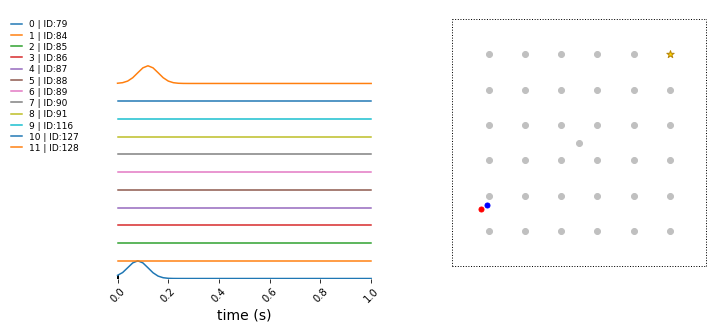

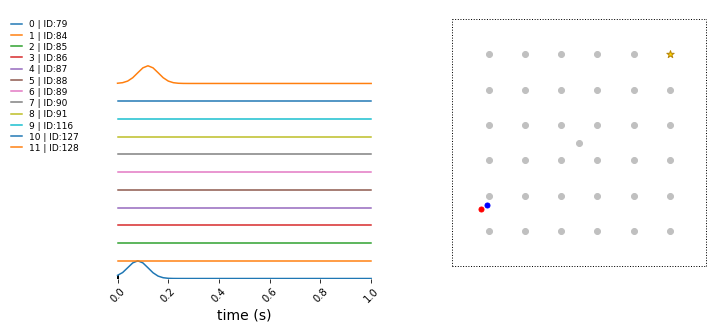

In [199]:
vid_24116.plotAllUnits(sessNum=30, timePoint=0)

In [ ]:
makeUnitAnimation2(self, sessNum=0)

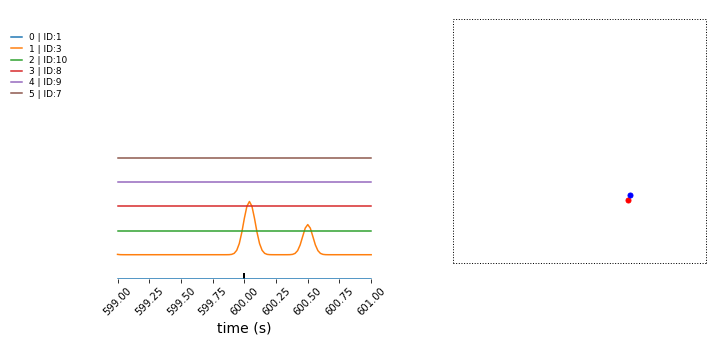

In [163]:
sessNum = 2
timePoint = 30000

# find number of cells in the session
numCells = len(vid_24116.SpikeTimes[sessNum][0])

fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# try to find y-lim of FR plot
allPeaks = np.array([]);
for unitNum in range(numCells):
    fr = vid_24116.instFR(sigma=2, sessNum=sessNum, unitNum=unitNum)
    maxVal = np.around(np.amax(fr), decimals=2);
    allPeaks = np.append(allPeaks, maxVal)
overallPeak = np.max(allPeaks)

y_offset = 0

for unitNum in range(numCells):
    
    # call 'getTimePt', 'getUnitData' and 'instFR' methods 
    time, led = vid_24116.getTimePt(sessNum, timePoint)
    window, spikesNow, info = vid_24116.getUnitData(sessNum, unitNum)
    fr = vid_24116.instFR(sigma=2, sessNum=sessNum, unitNum=unitNum)
    UID = vid_24116.getUID(sessNum, unitNum)
    
    # home well for current session?
    hwNow = hwLoc[sessNum]

    # calculate peak firing rate
    peakRate = np.around(np.amax(fr), decimals=2)

    # parse window vector
    scalingFactor = 1.25 # scale up min/max by some percentage
    minX = window[0]*scalingFactor; maxX = window[1]*scalingFactor; minY = window[2]*scalingFactor; maxY = window[3]*scalingFactor

    # compute space (x and y)-- this is to plot the grid
    xSpace = maxX-minX
    ySpace = maxY-minY


    # if size of the arena is not square, force aspect ratio
    # the idea here is that by shifting the arena to the right, we kind of force outliers out
    if xSpace > ySpace:
        diffSpace = xSpace-ySpace
        minX = minX + diffSpace # reshape the arena (make it square)
        numWells = 6 # in a single dimension
        Space = (maxY-minY)/(numWells+1) # space between points

    # parse led vector
    offset = 15 # how much to offset LEDs by
    time = led[0]
    L1A = led[1]; L1B = led[2]; L2A = led[3]+offset; L2B = led[4]+offset

    # call 'activityNow' method to get smoothed FR and time vector around the
    # timePoint of interest (+/- 1 second)
    fr, t = vid_24116.activityNow(sessNum=sessNum, unitNum=unitNum, timePoint=timePoint, sigma=2)
    
    ax1.plot(t, fr+y_offset, label=str(unitNum)+' | ID:'+str(UID));
    ax1.tick_params(axis='x', labelrotation=45)
    ax1.tick_params(left=False, labelleft=False)
    ax1.set_xlabel("time (s)", fontsize=14)
#     ax1.set_ylabel("fr (Hz)",fontsize=12)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.vlines(x = time, ymin = 0, ymax = 2, color='k', lw = 1.5) # current time
    ax1.set_ylim([0, allPeaks[-1]+(y_offset+(5*numCells))])
    
    y_offset = y_offset + 8


# ax1.legend()
ax1.legend(fontsize= 9, frameon= False,handlelength=1.25, labelspacing=.25, bbox_to_anchor=(-.35, .65), loc='lower left', borderaxespad=0)

ax2.hlines(y = minY, xmin = minX, xmax = maxX, linestyles=':', lw = 1); #minY
ax2.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles=':', lw = 1); # maxY
ax2.vlines(x = minX, ymin = minY, ymax = maxY, linestyles=':', lw = 1); # minX
ax2.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles=':', lw = 1); # maxX
ax2.scatter(L1A, L1B, s=25, color='red'); # plot data
ax2.scatter(L2A, L2B, s=25, color='blue'); # plot data
ax2.axis('off');
ax2.set_yticks([100, 200, 300, 400, 500]);
ax2.set_xticks([200, 300, 400, 500, 600]);